In [2]:


import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/dogs-vs-cats/sampleSubmission.csv
/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip


In [3]:
import zipfile

In [4]:

zip_ref = zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r')
zip_ref.extractall('/tmp/train')
zip_ref.close()

In [5]:
filenames = os.listdir("/tmp/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'label': categories
})

In [6]:
df.head()

,filename,label
0,dog.890.jpg,1
1,dog.1178.jpg,1
2,dog.7845.jpg,1
3,dog.4632.jpg,1
4,cat.3660.jpg,0


In [7]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, Input
import pandas as pd
import os
import numpy as np
from keras.models import load_model
import tensorflow as tf
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import cv2
import time
import h5py

In [8]:
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them

path="/tmp/train/train/"


# test=test.drop('label',1)
temp = []
for img_name in df.filename:
    image_path = path+img_name
    img = cv2.imread(image_path, 0)
    img = cv2.resize(img, (128, 128))
    img = img.reshape(1, 128 * 128)
    img = img.astype('float32')
    temp.append(img)


train_x = np.stack(temp)

train_x /= 255.0

train_x = train_x.reshape(len(df), 128,128,1).astype('float32')
train_y = to_categorical(df.label.values,num_classes=2)

print("no_prob")
train_x=np.array(train_x)
train_y=np.array(train_y)

x_train,x_test,y_train,y_test=train_test_split(train_x,train_y,test_size=0.2,random_state=4)
# time.sleep(10)

aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")


aug.fit(train_x)

[INFO] loading images...
no_prob


In [9]:
class CNNmodel:
    @staticmethod
    def build(width, height, depth, classes):
        
        model = Sequential()
        inputShape = (height, width, depth)
 
        
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        
        model.add(Conv2D(20, (5, 5), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))
 
    
        model.add(Dense(classes))
        model.add(Activation("sigmoid"))
 
        
        return model


In [10]:
print("[INFO] compiling model...")
model = CNNmodel.build(width=128, height=128, depth=1, classes=2)
opt = Adam(lr=0.0001, decay=1e-3 / 5)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])


print("[INFO] training network...")
H = model.fit_generator(aug.flow(x_train, y_train, batch_size=32),validation_data=(x_test, y_test),steps_per_epoch=len(x_train) // 32,epochs=5, verbose=1)


print("[INFO] serializing network...") 
model.save('modelingenius.h5')

[INFO] compiling model...
[INFO] training network...
Epoch 1/5
625/625 [==============================] - 394s 631ms/step - loss: 0.6516 - accuracy: 0.6138 - val_loss: 0.6269 - val_accuracy: 0.6302
Epoch 2/5
625/625 [==============================] - 397s 635ms/step - loss: 0.6003 - accuracy: 0.6746 - val_loss: 0.5394 - val_accuracy: 0.7284
Epoch 3/5
625/625 [==============================] - 392s 627ms/step - loss: 0.5781 - accuracy: 0.6977 - val_loss: 0.5318 - val_accuracy: 0.7396
Epoch 4/5
625/625 [==============================] - 397s 635ms/step - loss: 0.5598 - accuracy: 0.7103 - val_loss: 0.5118 - val_accuracy: 0.7534
Epoch 5/5
625/625 [==============================] - 395s 631ms/step - loss: 0.5477 - accuracy: 0.7162 - val_loss: 0.4897 - val_accuracy: 0.7640
[INFO] serializing network...


In [11]:
def plot_graph(H,EPOCHS,INIT_LR,BS):

    plt.style.use("ggplot")
    plt.figure()
    N = EPOCHS
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on our system")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    # plt.savefig(args["plot"])
    plt.show()

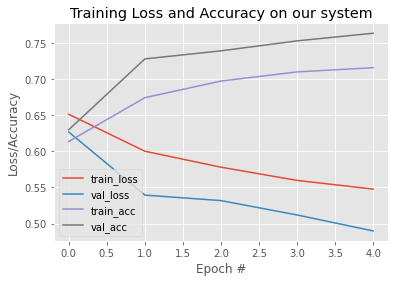

In [13]:
plot_graph(H,5,1e-3,32)